<a href="https://colab.research.google.com/github/fred-ykv/Value-Investing-In-Python/blob/master/VALUATION_FINVIZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [536]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as soup
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from urllib.request import Request, urlopen

pd.set_option('display.max_colwidth', 25)

In [537]:
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [538]:
!pip install yfinance

import yfinance as yf
yf.pdr_override()
import plotly.graph_objs as go
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [539]:
!pip install git+https://github.com/quantopian/pyfolio
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-7w08avwg
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-7w08avwg
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done


# Entrada do Ticker

In [540]:
symbol = input('Enter a ticker: ')
print ('Getting data for ' + symbol + '...\n')

Enter a ticker: wire
Getting data for wire...



# Set up scraper

In [541]:
url = ("http://finviz.com/quote.ashx?t=" + symbol.lower())
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
html = soup(webpage, "html.parser")

In [542]:
def get_fundamentals():
    try:
        # Find fundamentals table
        fundamentals = pd.read_html(str(html), attrs = {'class': 'snapshot-table2'})[0]
        
        # Clean up fundamentals dataframe
        fundamentals.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
        colOne = []
        colLength = len(fundamentals)
        for k in np.arange(0, colLength, 2):
            colOne.append(fundamentals[f'{k}'])
        attrs = pd.concat(colOne, ignore_index=True)
    
        colTwo = []
        colLength = len(fundamentals)
        for k in np.arange(1, colLength, 2):
            colTwo.append(fundamentals[f'{k}'])
        vals = pd.concat(colTwo, ignore_index=True)
        
        fundamentals = pd.DataFrame()
        fundamentals['Attributes'] = attrs
        fundamentals['Values'] = vals
        fundamentals = fundamentals.set_index('Attributes')
        return fundamentals

    except Exception as e:
        return e

In [543]:
def get_news():
    try:
        # Find news table
        news = pd.read_html(str(html), attrs = {'class': 'fullview-news-outer'})[0]
        links = []
        for a in html.find_all('a', class_="tab-link-news"):
            links.append(a['href'])
        
        # Clean up news dataframe
        news.columns = ['Date', 'News Headline']
        news['Article Link'] = links
        news = news.set_index('Date')
        return news

    except Exception as e:
        return e

In [544]:
def get_insider():
    try:
        # Find insider table
        insider = pd.read_html(str(html), attrs = {'class': 'body-table'})[0]
        
        # Clean up insider dataframe
        insider = insider.iloc[1:]
        insider.columns = ['Trader', 'Relationship', 'Date', 'Transaction', 'Cost', '# Shares', 'Value ($)', '# Shares Total', 'SEC Form 4']
        insider = insider[['Date', 'Trader', 'Relationship', 'Transaction', 'Cost', '# Shares', 'Value ($)', '# Shares Total', 'SEC Form 4']]
        insider = insider.set_index('Date')
        return insider

    except Exception as e:
        return e

In [545]:
print ('\nFundamental Ratios: ')
print(get_fundamentals())

print ('\nRecent News: ')
print(get_news())

print ('\nRecent Insider Trades: ')
print(get_insider())


Fundamental Ratios: 
                 Values
Attributes             
Index                 -
Market Cap        3.34B
Income          717.80M
Sales             3.02B
Book/sh           99.60
...                 ...
ATR                6.52
Volatility  3.17% 3.83%
Prev Close       176.76
Price            182.64
Change            3.33%

[72 rows x 1 columns]

Recent News: 
Length of values (100) does not match length of index (103)

Recent Insider Trades: 
                 Trader Relationship      Transaction    Cost # Shares  \
Date                                                                     
Feb 21  Ford Matthew D.   Controller             Sale  200.00     2725   
Feb 17  Ford Matthew D.   Controller             Sale  200.00      275   
Jul 21  Ford Matthew D.   Controller  Option Exercise   51.63     1000   

       Value ($) # Shares Total       SEC Form 4  
Date                                              
Feb 21    545000          34138  Feb 21 12:30 PM  
Feb 17     55000   

In [546]:
print ('Fundamental Ratios: ')
fundamentals = get_fundamentals()
if 'Market Cap' in fundamentals.index:
    print(fundamentals.loc['Market Cap'])
else:
    print('Market Cap is not listed.')

Fundamental Ratios: 
Values    3.34B
Name: Market Cap, dtype: object


Valor de Mercado

In [547]:
market_cap_str = fundamentals.loc['Market Cap']['Values']
market_cap_str = market_cap_str.strip()

if market_cap_str[-1] == 'B':
    market_cap = float(market_cap_str[:-1]) * 1000000000
elif market_cap_str[-1] == 'M':
    market_cap = float(market_cap_str[:-1]) * 1000000
else:
    market_cap = float(market_cap_str)

print(f'Market Cap: ${market_cap:,.2f}')

Market Cap: $3,340,000,000.00


ROI

In [548]:
roi_str = fundamentals.loc['ROI']['Values']
roi_str = roi_str.replace('%', '')
roi = float(roi_str)
roi_perc = roi/100
roi_perc_str = str(roi_perc).replace('.', ',')

print(f'ROI: {roi_perc_str}')

ROI: 0,389


ROE

In [549]:
roe_str = fundamentals.loc['ROE']['Values']
roe_str = roe_str.replace('%', '')
roe = float(roe_str)
roe_perc = roe/100
roe_perc_str = str(roe_perc).replace('.', ',')

print(f'ROE: {roe_perc_str}')

ROE: 0,44


Payout

In [550]:
payout_str = fundamentals.loc['Payout']['Values']
payout_str = payout_str.replace('%', '')
payout = float(payout_str)
payout_perc = payout/100
payout_perc_str = str(payout_perc).replace('.', ',')

print(f'Payout: {payout_perc_str}')

Payout: 0,002


Dividend Yield

In [551]:
div_str = fundamentals.loc['Dividend %']['Values']
div_str = div_str.replace('%', '')
div = float(div_str)
div_perc = div/100
div_perc_str = str(div_perc).replace('.', ',')

print(f'Dividend %: {div_perc_str}')

Dividend %: 0,0005


Crescimento dos Lucros nos próximos 5 anos

In [552]:
epsn5_str = fundamentals.loc['EPS next 5Y']['Values']
epsn5_str = epsn5_str.replace('%', '')
epsn5 = float(epsn5_str)
epsn5_perc = epsn5/100
epsn5_perc_str = str(epsn5_perc).replace('.', ',')

print(f'EPS next 5: {epsn5_perc_str}')

EPS next 5: 0,1


LPA - Lucro por Ação

In [553]:
eps_str = fundamentals.loc['EPS (ttm)']['Values']
eps = float(eps_str)
eps_str = str(eps).replace('.', ',')

print(f'EPS: {eps_str}')

EPS: 36,91


VPA - Valor Patrimonial por Ação

In [554]:
VPA_str = fundamentals.loc['Book/sh']['Values']
VPA = float(VPA_str)
VPA_str = str(VPA).replace('.', ',')

print(f'VPA: {VPA}')


VPA: 99.6


Beta

In [555]:
beta_str = fundamentals.loc['Beta']['Values']
beta = float(beta_str)
beta_str = str(beta).replace('.', ',')

print(f'Beta: {beta_str}')

Beta: 1,35


Taxa de Reinvestimento do Lucro Líquido

In [556]:
tax_reinvest_ll = 1 - payout_perc
tax_reinvest_ll_str = str(tax_reinvest_ll).replace('.', ',')

print(f'Taxa de Reinvestimento LL: {tax_reinvest_ll:.3f}')

Taxa de Reinvestimento LL: 0.998


gLL - Crescimento do Lucro Líquido

In [557]:
roe_str = fundamentals.loc['ROE']['Values']
roe_str = roe_str.replace('%', '')
roe = float(roe_str)
roe_perc = roe/100

gll = tax_reinvest_ll*roe_perc
gll_str = str(gll).replace('.', ',')

print(f'gLL: {gll:.3f}')

gLL: 0.439


Ganho de Alavancagem

In [558]:
gain_leverage = roe_perc - roi_perc
gain_leverage_str = str(gain_leverage).replace('.', ',')

print(f'Ganho de Alavancagem: {gain_leverage:.3f}')

Ganho de Alavancagem: 0.051


Grau de Alavancagem Financeira

In [559]:
gaf = roe_perc/roi_perc
gaf_str = str(gaf).replace('.', ',')

print(f'Grau de Alavancagem Financeira: {gaf:.3f}')

Grau de Alavancagem Financeira: 1.131


Taxa de Juros Livre de Risco (Rf) - Treasury Bond 10Y

In [560]:
# Requisição Url
url = "https://ycharts.com/indicators/10_year_treasury_rate"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()

# Parser
html = soup(webpage, "html.parser")

# Buscando Valor
xpath = '/html/body/main/div/div[2]/div/div/div[2]'
value_elem = html.find('div', {'class':'key-stat-title'}).get_text()

if value_elem is not None:
    value = value_elem.strip()
    value = value.split(' ')[0] # Removendo Strings
    value = value.replace('%', '')

    # Removendo Caracteres
    Rf = float(value.replace(',', '.'))
    Rf_str = str(Rf).replace('.', ',') + '%' # Corrigindo Erro

    print(f'Taxa de Juros Livre de Risco (Rf): {Rf_str}')

Taxa de Juros Livre de Risco (Rf): 3,55%


In [561]:
url = 'https://ycharts.com/indicators/us_10year_government_bond_interest_rate'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
html = soup(webpage, "html.parser")

xpath = '/html/body/main/div/div[2]/div/div/div[2]'
value_elem = html.find('div', {'class':'key-stat-title'}).get_text()

if value_elem is not None:
    value = value_elem.strip()
    value = value.split(' ')[0] # Removendo Strings
    value = value.replace('%', '')

    # Removendo Caracteres
    interest_rate = float(value.replace(',', '.'))
    interest_rate_str = str(interest_rate).replace('.', ',') + '%' # Corrigindo Erro

    print(f'Taxa de Juros Livre de Risco (Rf): {interest_rate_str}')

Taxa de Juros Livre de Risco (Rf): 3,75%


Taxa de Inflação Americana

In [562]:
# Requisição Url
url = "https://ycharts.com/indicators/us_consumer_price_index_yoy"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()

# Parser
html = soup(webpage, "html.parser")

# Buscando Valor
xpath = '/html/body/main/div/div[2]/div/div/div[2]'
value_elem = html.find('div', {'class':'key-stat-title'}).get_text()

if value_elem is not None:
    value = value_elem.strip()
    value = value.split(' ')[0] # Removendo Strings
    value = value.replace('%', '')

    # Removendo Caracteres
    inflation = float(value.replace(',', '.'))
    inflation_str = str(inflation).replace('.', ',') + '%' # Corrigindo Erro

    print(f'Taxa de Inflação Americana:: {inflation_str}')

Taxa de Inflação Americana:: 6,04%


S&P 500 - Retorno 10Y

In [563]:
def calcula_retorno(dataframe):
  df = dataframe.copy()  
  df['daily_return']        = df.iloc[:,0].pct_change()
  df['acum_return']         = (1 +  df['daily_return']).cumprod()
  df['acum_return'].iloc[0] = 1
  df.rename(columns={df.columns[0]: "price" }, inplace=True)
  return df

sp500 = yf.download('^GSPC')[['Adj Close']]
sp500

sp500 = calcula_retorno(sp500)
sp500

Ten_year_return = sp500['acum_return'].iloc[-1] * 100 - 100
print(f'Retorno acumulado 10Y: {Ten_year_return:.1f}%')

mean_yearly_return = sp500['daily_return'].mean() * 100 * 365
print(f'Retorno médio anual 10Y: {mean_yearly_return:.2f}%')


[*********************100%***********************]  1 of 1 completed
Retorno acumulado 10Y: 22054.4%
Retorno médio anual 10Y: 10.88%


In [564]:
url = 'https://br.investing.com/economic-calendar/brazilian-cpi-410'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
html = soup(webpage, "html.parser")

xpath = '/html/body/div[5]/section/div[6]/span[2]/div'
value_elem = html.find('div', {'class':'inner_cell'})

if value_elem is not None:
    value = value_elem.get_text().strip()

    # Removendo Caracteres
    interest_rate = float(value.replace(',', '.'))
    interest_rate_str = str(interest_rate).replace('.', ',') + '%' # Corrigindo Erro

    print(f'Taxa de Juros Livre de Risco (Rf): {interest_rate_str}')

Taxa de Inflação Brasil

In [565]:
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen

url = 'https://www.bcb.gov.br/'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
html = soup(webpage, "html.parser")

value_elem = html.select_one('div.valor')

if value_elem is not None:
    value = value_elem.get_text().strip()
    value = value.split(' ')[0] # Removendo Strings
    value = value.replace('%', '')

    # Removendo Caracteres
    interest_rate = float(value.replace(',', '.'))
    interest_rate_str = str(interest_rate).replace('.', ',') + '%' # Corrigindo Erro

    print(f'Taxa de Juros Livre de Risco (Rf): {interest_rate_str}')

In [566]:
import requests
import pandas as pd

#Define o codigo da série temporal
codigo_bcb = 433

#Realiza a requisição à API do BCB
url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json&dataInicial=12-months-ago&dataFinal=today'.format(codigo_bcb)
request = requests.get(url)
data = request.json()

#Cria o DataFrame com os dados
df = pd.DataFrame(data)
df['data'] = pd.to_datetime(df['data'], dayfirst=True)
df.set_index('data', inplace=True)

#Exibe as últimas 12 taxas de inflação mensal
print(df['valor'].tail(12))

#Cria o DataFrame com os dados
df = pd.DataFrame(data)
df['data'] = pd.to_datetime(df['data'], dayfirst=True)
df.set_index('data', inplace=True)

#Cria uma variável com os 12 últimos valores
inflacao_anual = df['valor'].tail(12).astype(float).sum()

#Imprime a taxa de inflação anual
print("Taxa de inflação anual: {:.2f}%".format(inflacao_anual))

data
2022-03-01     1.62
2022-04-01     1.06
2022-05-01     0.47
2022-06-01     0.67
2022-07-01    -0.68
2022-08-01    -0.36
2022-09-01    -0.29
2022-10-01     0.59
2022-11-01     0.41
2022-12-01     0.62
2023-01-01     0.53
2023-02-01     0.84
Name: valor, dtype: object
Taxa de inflação anual: 5.48%


# **Balanço Patrimonial**

In [567]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.zacks.com/stock/quote/'+ symbol +'/balance-sheet'
user_agent = {'User-agent': 'Mozilla/5.0'}

# Obtendo a página
page = requests.get(url, headers = user_agent)

# Criando o objeto BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

# Extraindo os valores da tabela
table_rows = soup.find_all('tr')
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    print(row)

[]
['Strong Buy', '24.52%']
['Buy', '18.26%']
['Hold', '9.60%']
['Sell', '5.38%']
['Strong Sell', '2.61%']
['500', '10.68%']
['A']
['A']
['A']
['A']
[]
['Assets', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0']
['Cash & Equivalents', '731', '439', '183', '231', '178']
['Receivables', '514', '492', '277', '227', '237']
['Notes Receivable', '0', '0', '0', '0', '0']
['Inventories', '153', '101', '92', '90', '102']
['Other Current Assets', '4', '3', '3', '2', '2']
['Total Current Assets', '1,402', '1,035', '555', '549', '519']
['Net Property & Equipment', '617', '495', '411', '333', '299']
['Investments & Advances', '0', '0', '0', '0', '0']
['Other Non-Current Assets', '0', '0', '0', '0', '0']
['Deferred Charges', '0', '0', '0', '0', '0']
['Intangibles', '0', '0', '0', '0', '0']
['Deposits & Other Assets', '0', '1', '1', '1', '0']
['Total Assets', '2,019', '1,531', '966', '883', '818']
[]
['Notes Payable', '0', '0', '0', '0', '0']
['Accounts Payable', '63', '75', '57', '41', '37']
['Current Portio

Patrimônio Líquido (PL)

In [568]:
# Encontrando o valor de Total Shareholder's Equity
total_shareholders_equity = soup.find('td', text="Total Shareholder's Equity")
value = total_shareholders_equity.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions_12 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
value_formatted = '${:,.2f}'.format(value_in_millions_12)

# Imprimindo o valor formatado
print(value_formatted)


$1,819,000,000.00


Empréstimos e Financiamentos

In [569]:
# Encontrando o valor de Current Portion Long-Term Debt
current_portion_longterm_debt = soup.find('td', text="Current Portion Long-Term Debt")
value = current_portion_longterm_debt.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions)

# Imprimindo o valor formatado
print('Empréstimos e Financiamentos:', value_formatted)

Empréstimos e Financiamentos: $ 0.00


Dívida de Longo Prazo

In [570]:
# Encontrando o valor de Long-Term Debt
longterm_debt = soup.find('td', text="Long-Term Debt")
value = longterm_debt.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions)

# Imprimindo o valor formatado
print('Dívida de Longo Prazo:', value_formatted)

Dívida de Longo Prazo: $ 0.00


Capital de Terceiros (Po)

In [571]:
# Encontrando o valor de Current Portion Long-Term Debt
current_portion_longterm_debt = soup.find('td', text="Current Portion Long-Term Debt")
value = current_portion_longterm_debt.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
current_portion_longterm_debt_in_millions = float(value.replace(',', '')) * 1000000

# Encontrando o valor de Long-Term Debt
longterm_debt = soup.find('td', text="Long-Term Debt")
value = longterm_debt.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
longterm_debt_in_millions = float(value.replace(',', '')) * 1000000

# Somando os valores de Current Portion Long-Term Debt e Long-Term Debt
total_debt = current_portion_longterm_debt_in_millions + longterm_debt_in_millions

# Formatando o valor de volta para uma string com a notação de dólares
if total_debt == 0:
  total_debt_formatted = '$ 0.00'
else:
  total_debt_formatted = '${:,.2f}'.format(total_debt)

# Imprimindo o valor formatado
print('Capital de Terceiros (PO):', total_debt_formatted)


Capital de Terceiros (PO): $ 0.00


Capital Investido (Ativos Totais)

In [572]:
# Encontrando o valor de Total Assets
total_assets = soup.find('td', text="Total Assets")
value = total_assets.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions)

# Imprimindo o valor formatado
print('Capital Investido (Ativos Totais):', value_formatted)

Capital Investido (Ativos Totais): $2,019,000,000.00


Caixa e Aplicações Financeiras

In [573]:
# Encontrando o valor de Cash & Equivalents
cash_equivalents = soup.find('td', text="Cash & Equivalents")
value = cash_equivalents.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions)

# Imprimindo o valor formatado
print('Caixa e Aplicações Financeiras:', value_formatted)

Caixa e Aplicações Financeiras: $731,000,000.00


Ativo Circulante

In [574]:
# Encontrando o valor de Total Current Assets
total_current_assets = soup.find('td', text="Total Current Assets")
value = total_current_assets.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions)

# Imprimindo o valor formatado
print('Ativo Circulante:', value_formatted)

Ativo Circulante: $1,402,000,000.00


Ativo Circulante Operacional

In [575]:
# Encontrando o valor de Total Current Assets
total_current_assets = soup.find('td', text="Total Current Assets")
value_assets = total_current_assets.find_next('td').text

# Encontrando o valor de Cash & Equivalents
cash_equivalents = soup.find('td', text="Cash & Equivalents")
value_cash = cash_equivalents.find_next('td').text

# Removendo as vírgulas e convertendo os valores para float
value_assets_in_millions = float(value_assets.replace(',', '')) * 1000000
value_cash_in_millions = float(value_cash.replace(',', '')) * 1000000

# Calcular o Ativo Circulante Operacional
value_operational_1 = value_assets_in_millions - value_cash_in_millions

# Formatando o valor de volta para uma string com a notação de dólares
if value_operational_1 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_operational_1)

# Imprimindo o valor formatado
print('Ativo Circulante Operacional:', value_formatted)

Ativo Circulante Operacional: $671,000,000.00


Passivo Circulante

In [576]:
# Encontrando o valor de Total Current Liabilities
total_current_liabilities = soup.find('td', text="Total Current Liabilities")
value = total_current_liabilities.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions)

# Imprimindo o valor formatado
print('Passivo Circulante:', value_formatted)

Passivo Circulante: $144,000,000.00


Passivo Circulante Operacional

In [577]:
# Encontrando o valor de Total Current Liabilities
total_current_liabilities = soup.find('td', text="Total Current Liabilities")
value_liabilities = total_current_liabilities.find_next('td').text

# Encontrando o valor de Current Portion Long-Term Debt
current_portion_longterm_debt = soup.find('td', text="Current Portion Long-Term Debt")
value_debt = current_portion_longterm_debt.find_next('td').text

# Removendo as vírgulas e convertendo os valores para float
value_liabilities_in_millions = float(value_liabilities.replace(',', '')) * 1000000
value_debt_in_millions = float(value_debt.replace(',', '')) * 1000000

# Calcular o Passivo Circulante Operacional
value_operational_2 = value_liabilities_in_millions - value_debt_in_millions

# Formatando o valor de volta para uma string com a notação de dólares
if value_operational_2 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_operational_2)

# Imprimindo o valor formatado
print('Passivo Circulante Operacional:', value_formatted)

Passivo Circulante Operacional: $144,000,000.00


## Cash Flow Statements

In [578]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.zacks.com/stock/quote/'+ symbol +'/cash-flow-statements'
user_agent = {'User-agent': 'Mozilla/5.0'}

# Obtendo a página
page = requests.get(url, headers = user_agent)

# Criando o objeto BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

# Extraindo os valores da tabela
table_rows = soup.find_all('tr')
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    print(row)

[]
['Strong Buy', '24.52%']
['Buy', '18.26%']
['Hold', '9.60%']
['Sell', '5.38%']
['Strong Sell', '2.61%']
['500', '10.68%']
['A']
['A']
['A']
['A']
[]
['Cash Flow From Operations, Investments & Financial Activities', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0']
['Net Income (Loss)', '717.84', '541.42', '76.07', '58.13', '78.15']
['Depreciation/Amortization & Depletion', '26.23', '23.29', '19.46', '17.71', '16.51']
['Net Change from Assets/Liabilities', '-87.19', '-158.17', '-46.84', '24.54', '-17.36']
['Net Cash from Discontinued Operations', '0.00', '0.00', '0.00', '0.00', '0.00']
['Other Operating Activities', '32.00', '11.88', '8.78', '5.75', '4.29']
['Net Cash From Operating Activities', '688.88', '418.42', '57.46', '106.12', '81.59']
['Property & Equipment', '-148.35', '-118.16', '-85.99', '-52.46', '-26.07']
['Acquisition/ Disposition of Subsidiaries', '0.00', '0.00', '0.00', '0.00', '0.00']
['Investments', '0.00', '0.00', '0.00', '0.00', '0.00']
['Other Investing Activities', '0.00'

Despesa Financeira

In [579]:
# Encontrando o valor de Issuance (Repayment) of Debt
issuance_repayment_of_debt = soup.find('td', text="Issuance (Repayment) of Debt")
value = issuance_repayment_of_debt.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions)

# Imprimindo o valor formatado
print('Despesa Financeira:', value_formatted)

Despesa Financeira: $ 0.00


Depreciação e Amortização

In [580]:
# Encontrando o valor de Depreciação e Amortização
Depreciation_Amortization_Depletion = soup.find('td', text="Depreciation/Amortization & Depletion")
value = Depreciation_Amortization_Depletion.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions_7 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_7 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_7)

# Imprimindo o valor formatado
print('Depreciação e Amortização:', value_formatted)

Depreciação e Amortização: $26,230,000.00


CAPEX

In [581]:
# Encontrando o valor de CAPEX
Property_Equipment = soup.find('td', text="Property & Equipment")
value = Property_Equipment.find_next('td').text

# Removendo as vírgulas e o símbolo negativo, caso exista
if value[0] == '-':
  value_in_millions_8 = float(value[1:].replace(',', '')) * 1000000
else:
  value_in_millions_8 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_8 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_8)

# Imprimindo o valor formatado
print('CAPEX:', value_formatted)

CAPEX: $148,350,000.00


Aquisição / Alienação de Subsidiárias

In [582]:
# Encontrando o valor de Aquisição / Alienação de Subsidiárias
Acquisition = soup.find('td', text="Acquisition/ Disposition of Subsidiaries")
value = Acquisition.find_next('td').text

# Removendo as vírgulas e o símbolo negativo, caso exista
if value == 'NA':
  value_in_millions_9 = 0
elif value[0] == '-':
  value_in_millions_9 = float(value[1:].replace(',', '')) * 1000000
else:
  value_in_millions_9 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_9 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_9)

# Imprimindo o valor formatado
print('Aquisição / Alienação de Subsidiárias:', value_formatted)

Aquisição / Alienação de Subsidiárias: $ 0.00


Investimentos

In [583]:
# Encontrando o valor de Investimentos
Investments = soup.find('td', text="Investments")
value = Investments.find_next('td').text

# Removendo as vírgulas e o símbolo negativo, caso exista
if value[0] == '-':
  value_in_millions_10 = float(value[1:].replace(',', '')) * 1000000
else:
  value_in_millions_10 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_10 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_10)

# Imprimindo o valor formatado
print('Investimentos:', value_formatted)

Investimentos: $ 0.00


Outras atividades de investimento

In [584]:
# Encontrando o valor de Outras atividades de investimento
Other_Investing_Activities = soup.find('td', text="Other Investing Activities")
value = Investments.find_next('td').text

# Removendo as vírgulas e o símbolo negativo, caso exista
if value[0] == '-':
  Other_Investing_Activities = float(value[1:].replace(',', '')) * 1000000
else:
  Other_Investing_Activities = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if Other_Investing_Activities == 0:
  Other_Investing_Activities_formatted = '$ 0.00'
else:
  Other_Investing_Activities_formatted = '${:,.2f}'.format(Other_Investing_Activities)

# Imprimindo o valor formatado
print('Outras atividades de investimento:', Other_Investing_Activities_formatted)

Outras atividades de investimento: $ 0.00


Fluxo de Caixa das atividades de investimentos

In [585]:
# Calculando FC das atividades de investimentos
FCAI = value_in_millions_8 + value_in_millions_9 + value_in_millions_10 + Other_Investing_Activities

# Formatando o valor de volta para uma string com a notação de dólares
if FCAI == 0:
  FCAI_formatted = '$ 0.00'
else:
  FCAI_formatted = '${:,.2f}'.format(FCAI)

# Imprimindo o valor formatado
print('FCAI:', FCAI_formatted)

FCAI: $148,350,000.00


## DRE

In [586]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.zacks.com/stock/quote/'+ symbol +'/income-statement'
user_agent = {'User-agent': 'Mozilla/5.0'}

# Obtendo a página
page = requests.get(url, headers = user_agent)

# Criando o objeto BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

# Extraindo os valores da tabela
table_rows = soup.find_all('tr')
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    print(row)

[]
['Strong Buy', '24.52%']
['Buy', '18.26%']
['Hold', '9.60%']
['Sell', '5.38%']
['Strong Sell', '2.61%']
['500', '10.68%']
['A']
['A']
['A']
['A']
[]
['Sales', '3,018', '2,593', '1,277', '1,275', '1,289']
['Cost Of Goods', '1,905', '1,725', '1,082', '1,109', '1,099']
['Gross Profit', '1,112', '868', '195', '166', '190']
['Selling & Adminstrative & Depr. & Amort Expenses', '197', '169', '97', '94', '90']
['Income After Depreciation & Amortization', '915', '699', '98', '72', '100']
['Non-Operating Income', '10', '0', '1', '4', '2']
['Interest Expense', '0', '0', '0', '0', '0']
['Pretax Income', '925', '699', '99', '76', '102']
['Income Taxes', '207', '158', '23', '18', '24']
['Minority Interest', '0', '0', '0', '0', '0']
['Investment Gains/Losses', '0', '0', '0', '0', '0']
['Other Income/Charges', '0', '0', '0', '0', '0']
['Income From Cont. Operations', '718', '541', '76', '58', '78']
['Extras & Discontinued Operations', '0', '0', '0', '0', '0']
['Net Income (GAAP)', '718', '541', '76

Receita

In [587]:
# Encontrando o valor de Sales
Sales = soup.find('td', text="Sales")
value = Sales.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions)

# Imprimindo o valor formatado
print('Receita:', value_formatted)

Receita: $3,018,000,000.00


Custos

In [588]:
# Encontrando o valor de Cost of Goods
Cost_of_Goods = soup.find('td', text="Cost Of Goods")
value = Cost_of_Goods.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions_1 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_1 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_1)

# Imprimindo o valor formatado
print('Custos:', value_formatted)

Custos: $1,905,000,000.00


Resultado Bruto

In [589]:
# Encontrando o valor de Resultado Bruto
Resultado_Bruto = value_in_millions - value_in_millions_1
Resultado_Bruto 

if Resultado_Bruto == 0:
  Resultado_Bruto_formatted = '$ 0.00'
else:
  Resultado_Bruto_formatted = '${:,.2f}'.format(Resultado_Bruto)

# Imprimindo o valor formatado
print('Resultado Bruto:', Resultado_Bruto_formatted)

Resultado Bruto: $1,113,000,000.00


**EBIT**

In [590]:
# Encontrando o valor de Pretax Income
Pretax_Income = soup.find('td', text="Pretax Income")
value = Pretax_Income.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions_2 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_2 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_2)

# Imprimindo o valor formatado
print('EBIT:', value_formatted)

EBIT: $925,000,000.00


**EBITDA**

In [591]:
# Encontrando o valor de EBITDA
EBITDA = value_in_millions_2 + value_in_millions_7
EBITDA 

if EBITDA == 0:
  EBITDA_formatted = '$ 0.00'
else:
  EBITDA_formatted = '${:,.2f}'.format(EBITDA)

# Imprimindo o valor formatado
print('EBITDA:', EBITDA_formatted)

EBITDA: $951,230,000.00


IR

In [592]:
# Encontrando o valor de Income Taxes
Income_Taxes = soup.find('td', text="Income Taxes")
value = Income_Taxes.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions_3 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_3 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_3)

# Imprimindo o valor formatado
print('IR:', value_formatted)

IR: $207,000,000.00


# *NOPAT Restrito* 

In [593]:
# Encontrando o valor de NOPAT Restrito
NOPAT_Restrito = value_in_millions_2 - value_in_millions_3
NOPAT_Restrito 

if NOPAT_Restrito == 0:
  NOPAT_Restrito_formatted = '$ 0.00'
else:
  NOPAT_Restrito_formatted = '${:,.2f}'.format(NOPAT_Restrito)

# Imprimindo o valor formatado
print('NOPAT Restrito:', NOPAT_Restrito_formatted)

NOPAT Restrito: $718,000,000.00


Depesa Financeira

In [594]:
# Encontrando o valor de Investment Gains/Losses
Investment_Gains_Losses = soup.find('td', text="Investment Gains/Losses")
value = Investment_Gains_Losses.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions_4 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_4 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_4)

# Imprimindo o valor formatado
print('Despesa Financeira:', value_formatted)

Despesa Financeira: $ 0.00


Lucro Líquido

In [595]:
# Encontrando o valor de Net Income (GAAP)
Net_Income_GAAP = soup.find('td', text="Net Income (GAAP)")
value = Net_Income_GAAP.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions_5 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_5 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_5)

# Imprimindo o valor formatado
print('Lucro Líquido:', value_formatted)

Lucro Líquido: $718,000,000.00


## **FCL**

NOPAT Restrito

In [596]:
# Encontrando o valor de NOPAT Restrito
NOPAT_Restrito = value_in_millions_2 - value_in_millions_3
NOPAT_Restrito 

if NOPAT_Restrito == 0:
  NOPAT_Restrito_formatted = '$ 0.00'
else:
  NOPAT_Restrito_formatted = '${:,.2f}'.format(NOPAT_Restrito)

# Imprimindo o valor formatado
print('NOPAT Restrito:', NOPAT_Restrito_formatted)

NOPAT Restrito: $718,000,000.00


Depreciação e Amortização

In [597]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.zacks.com/stock/quote/'+ symbol +'/cash-flow-statements'
user_agent = {'User-agent': 'Mozilla/5.0'}

# Obtendo a página
page = requests.get(url, headers = user_agent)

# Criando o objeto BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

# Extraindo os valores da tabela
table_rows = soup.find_all('tr')
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    
# Encontrando o valor de Depreciação e Amortização
Depreciation_Amortization_Depletion = soup.find('td', text="Depreciation/Amortization & Depletion")
value = Depreciation_Amortization_Depletion.find_next('td').text

# Removendo as vírgulas e convertendo o valor para float
value_in_millions_7 = float(value.replace(',', '')) * 1000000

# Formatando o valor de volta para uma string com a notação de dólares
if value_in_millions_7 == 0:
  value_formatted = '$ 0.00'
else:
  value_formatted = '${:,.2f}'.format(value_in_millions_7)

# Imprimindo o valor formatado
print('Depreciação e Amortização:', value_formatted)

Depreciação e Amortização: $26,230,000.00


FCO

In [598]:
# Calculando FCO
FCO = NOPAT_Restrito + value_in_millions_7

# Formatando o valor de volta para uma string com a notação de dólares
if FCO == 0:
  FCO_formatted = '$ 0.00'
else:
  FCO_formatted = '${:,.2f}'.format(FCO)

# Imprimindo o valor formatado
print('FCO:', FCO_formatted)

FCO: $744,230,000.00


Δ NC Giro

In [599]:
# Calculando NC Giro
NC_Giro = value_operational_1 - value_operational_2

# Formatando o valor de volta para uma string com a notação de dólares
if NC_Giro == 0:
  NC_Giro_formatted = '$ 0.00'
else:
  NC_Giro_formatted = '${:,.2f}'.format(NC_Giro)

# Imprimindo o valor formatado
print('Δ NC Giro:', NC_Giro_formatted)

Δ NC Giro: $527,000,000.00


CAPEX

In [600]:
CAPEX_formatted = '${:,.2f}'.format(value_in_millions_8)
print('CAPEX:', CAPEX_formatted)

CAPEX: $148,350,000.00


FCFF

In [601]:
# Calculando FCFF
if NC_Giro > 0:
  FCFF = FCO - NC_Giro - value_in_millions_8
elif NC_Giro < 0:
  FCFF = FCO + NC_Giro - value_in_millions_8

# Formatando o valor de volta para uma string com a notação de dólares
if FCFF == 0:
  FCFF_formatted = '$ 0.00'
else:
  FCFF_formatted = '${:,.2f}'.format(FCFF)

# Imprimindo o valor formatado
print('FCFF:', FCFF_formatted)

FCFF: $68,880,000.00


Novas Dívidas

In [602]:
# Calculando Novas Dívidas
Novas_dividas = value_in_millions_9 + value_in_millions_10

# Formatando o valor de volta para uma string com a notação de dólares
if Novas_dividas == 0:
  Novas_dividas_formatted = '$ 0.00'
else:
  Novas_dividas_formatted = '${:,.2f}'.format(Novas_dividas)

# Imprimindo o valor formatado
print('Novas Dívidas:', Novas_dividas_formatted)

Novas Dívidas: $ 0.00


IR

In [603]:
# Imprimindo o valor formatado
IR_formatted = '${:,.2f}'.format(value_in_millions_3)
print('IR:', IR_formatted)

IR: $207,000,000.00


**FCDA**

In [604]:
# Calculando FCDA
FCDA = FCFF + Novas_dividas + value_in_millions_3

# Formatando o valor de volta para uma string com a notação de dólares
if FCDA == 0:
  FCDA_formatted = '$ 0.00'
else:
  FCDA_formatted = '${:,.2f}'.format(FCDA)

# Imprimindo o valor formatado
print('FCDA:', FCDA_formatted)

FCDA: $275,880,000.00


# **CAPM - Custo do Capital Próprio**

Custo de Capital Próprio

In [605]:
# Calculando Ke

Ke = interest_rate + (beta*((mean_yearly_return) - interest_rate))
Ke_formatted = '{:,.2f}%'.format(Ke)
print ('Ke:' ,Ke_formatted)

Ke: 13.37%


Ki (Kd) - Custo da Dívida

In [606]:
# Calculando Ki (Kd) - Custo da Dívida
if value_in_millions_4 == 0:
  Ki = Rf + inflation
else:
  Ki = (value_in_millions_4 / total_debt) + 1

# Formatando o valor de volta para uma string com a notação de dólares
if Ki == 0:
  Ki_formatted = ' 0.00 %'
else:
  Ki_formatted = '{:,.2f} %'.format(Ki)

# Imprimindo o valor formatado
print('Ki (Kd) - Custo da Dívida:', Ki_formatted)

Ki (Kd) - Custo da Dívida: 9.59 %


Po e PL

In [607]:
Po = total_debt
PL = value_in_millions_12
Po_formatted = '${:,.2f}'.format(total_debt)
PL_formatted = '${:,.2f}'.format(value_in_millions_12)
print ('PL:' , PL_formatted)
print ('Po:' , Po_formatted)

PL: $1,819,000,000.00
Po: $0.00


PL / (Po+PL)

In [608]:
# Calculando PL / (Po+PL)
if value_in_millions_12 == 0:
  PL_Po_PL = 0.0
else:
  PL_Po_PL = value_in_millions_12 / (value_in_millions_12 + total_debt)

# Formatando o valor de volta para uma string com a notação de dólares
if PL_Po_PL == 0:
   PL_Po_PL_formatted = ' 0.0'
else:
  PL_Po_PL_formatted = '{:,.2f}'.format(PL_Po_PL)

# Imprimindo o valor formatado
print('PL / (Po+PL):', PL_Po_PL_formatted)

PL / (Po+PL): 1.00


Po / (Po+PL)

In [609]:
# Calculando Po / (Po+PL)
if total_debt == 0:
  Po_Po_PL = 0.0
else:
  Po_Po_PL = total_debt / (value_in_millions_12 + total_debt)

# Formatando o valor de volta para uma string com a notação de dólares
if Po_Po_PL == 0:
   Po_Po_PL_formatted = ' 0.0'
else:
  Po_Po_PL_formatted = '{:,.2f}'.format(Po_Po_PL)

# Imprimindo o valor formatado
print('Po / (Po+PL):', Po_Po_PL_formatted)

Po / (Po+PL):  0.0


**WACC**

In [610]:
# Calculando WACC
wacc = (Ke * PL_Po_PL ) + (Ki * Po_Po_PL)
wacc_formatted = '{:,.2f}%'.format(wacc)
print ('WACC:' , wacc_formatted)

WACC: 13.37%


**Custo de Oportunidade**

In [611]:
# Calculando Co = PL/Ke
Co = value_in_millions_12/(Ke/100)
Co_formatted = '${:,.2f}'.format(Co)
print ('Co:' , Co_formatted)


Co: $13,604,145,004.87


**Lucro Econômico (EVA)**

In [612]:
# Calculando LE = LL - Co
LE = value_in_millions_5 - Co
LE_formatted = '${:,.2f}'.format(LE)
print ('LE:' , LE_formatted)


LE: $-12,886,145,004.87


**AVALIAÇÃO PELO LUCRO EM EXCESSO**

In [613]:
# Calculando Vo = Capital Investido + PV do Retorno em Excesso
#PV do Retorno em Excesso = Goodwill

Goodwill = LE / Ke
Goodwill_formatted = '${:,.2f}'.format(Goodwill)
print('Goodwill',Goodwill_formatted)

Vo_excesso = PL + Goodwill
Vo_excesso_formatted = '${:,.2f}'.format(Vo_excesso)
print('Vo',Vo_excesso_formatted)


Goodwill $-963,743,733.92
Vo $855,256,266.08


ROE > KE

In [614]:
# Calcular a diferença entre o ROE e o ke
ROE_KE = roe - Ke

print('ROE: {:.2f}%'.format(roe))
print('KE: {:.2f}%'.format(Ke))
print('Diferença de ROE x Ke: {:.2f}%'.format(ROE_KE))

if ROE_KE > 0:
    print("SIM, ROE é maior que KE")
elif ROE_KE < 0:
    print("NÃO, ROE é menor que KE")
else:
    print("IGUAL, ROE é igual a KE")

ROE: 44.00%
KE: 13.37%
Diferença de ROE x Ke: 30.63%
SIM, ROE é maior que KE


ROI > WACC

In [615]:
# Calcular a diferença entre o ROI e o WACC
ROI_WACC = roi - wacc

print('ROI: {:.2f}%'.format(roi))
print('WACC: {:.2f}%'.format(wacc))
print('Diferença de ROI x WACC: {:.2f}%'.format(ROI_WACC))

if ROI_WACC > 0:
    print("SIM, ROI é maior que WACC")
elif ROI_WACC < 0:
    print("NÃO, ROI é menor que WACC")
else:
    print("IGUAL, ROI é igual a WACC")

ROI: 38.90%
WACC: 13.37%
Diferença de ROI x WACC: 25.53%
SIM, ROI é maior que WACC


# **Valuation**

***Nº de Ações***

In [616]:
# Localizando o número de ações
shs_outstand_str = fundamentals.loc['Shs Outstand']['Values']
shs_outstand_str = shs_outstand_str.strip()

if shs_outstand_str[-1] == 'B':
    shs_outstand = float(shs_outstand_str[:-1]) * 1000000000
elif shs_outstand_str[-1] == 'M':
    shs_outstand = float(shs_outstand_str[:-1]) * 1000000
else:
    shs_outstand = float(shs_outstand_str)

shs_outstand_formatted = '{:,d}'.format(int(shs_outstand))

print(f'Nº de Ações: {shs_outstand_formatted}')

Nº de Ações: 18,260,000


**gLL**

In [617]:
gll
print(f'gLL: {gll_str}')

gLL: 0,43912


**bNOPAT**

In [618]:
# Calculando bNOPAT
#bNOPAT = (CAPEX - Amortização e Depeciação) / EBIT
bNOPAT = (value_in_millions_8 - value_in_millions_7)/value_in_millions_2

print(bNOPAT)

0.13202162162162162


**gNOPAT**

In [619]:
# Calculando gNOPAT
# gNOPAT = bNOPAT * ROI
gNOPAT = bNOPAT * roi_perc
print (gNOPAT)

0.05135641081081081


**Crescimeto na perpetuidade**

In [620]:
# Calculando Crescimeto na perpetuidade
CP = 2/100
CP

0.02

**FCFF**

In [621]:
FCFF
# Imprimindo o valor formatado
print('FCFF:', FCFF_formatted)

FCFF: $68,880,000.00


**VP**

In [622]:
# A Taxa de desconto é calculada usando a formula (1+wacc)^n
# Ano 0
Ano_0 = 0
EBITDA_0 = 0.0
FCDE_0 = FCFF
Taxa_Desconto_0 = 0.0
VP_0 = FCDE_0

# Ano 1
Ano_1 = 1
EBITDA_1 = FCDE_0 * gll
FCDE_1 = FCDE_0 + EBITDA_1
Taxa_Desconto_1 = pow (1 + wacc/100, Ano_1)
VP_1 = FCDE_1/Taxa_Desconto_1

# Ano 2
Ano_2 = 2
EBITDA_2 = FCDE_1 * gll
FCDE_2 = FCDE_1 + EBITDA_2
Taxa_Desconto_2 = pow (1 + wacc/100, Ano_2)
VP_2 = FCDE_2/Taxa_Desconto_2

# Ano 3
Ano_3 = 3
EBITDA_3 = FCDE_2 * gll
FCDE_3 = FCDE_2 + EBITDA_3
Taxa_Desconto_3 = pow (1 + wacc/100, Ano_3)
VP_3 = FCDE_3/Taxa_Desconto_3

# Ano 4
Ano_4 = 4
EBITDA_4 = FCDE_3 * gll
FCDE_4 = FCDE_3 + EBITDA_4
Taxa_Desconto_4 = pow (1 + wacc/100, Ano_4)
VP_4 = FCDE_4/Taxa_Desconto_4

# Ano 5
Ano_5 = 5
EBITDA_5 = FCDE_4 * gll
FCDE_5 = FCDE_4 + EBITDA_5
Taxa_Desconto_5 = pow (1 + wacc/100, Ano_5)
VP_5 = FCDE_5/Taxa_Desconto_5

# Ano 6
Ano_6 = 6
EBITDA_6 = FCDE_5 * gll
FCDE_6 = FCDE_5 + EBITDA_6
Taxa_Desconto_6 = pow (1 + wacc/100, Ano_6)
VP_6 = FCDE_6/Taxa_Desconto_6

# Ano 7
Ano_7 = 7
EBITDA_7 = FCDE_6 * gll
FCDE_7 = FCDE_6 + EBITDA_7
Taxa_Desconto_7 = pow (1 + wacc/100, Ano_7)
VP_7 = FCDE_7/Taxa_Desconto_7

# Ano 8
Ano_8 = 8
EBITDA_8 = FCDE_7 * gll
FCDE_8 = FCDE_7 + EBITDA_8
Taxa_Desconto_8 = pow (1 + wacc/100, Ano_8)
VP_8 = FCDE_8/Taxa_Desconto_8

# Ano 9 
Ano_9 = 9
EBITDA_9 = FCDE_8 * gll
FCDE_9 = FCDE_8 + EBITDA_9
Taxa_Desconto_9 = pow (1 + wacc/100, Ano_9)
VP_9 = FCDE_9/Taxa_Desconto_9

# Ano 10 
Ano_10 = 10
EBITDA_10 = FCDE_9 * gll
FCDE_10 = FCDE_9 + EBITDA_10
Taxa_Desconto_10 = pow (1 + wacc/100, Ano_10)
VP_10 = FCDE_10/Taxa_Desconto_10

# Ano 11 - Perpetuidade
Ano_11 = 11
FCDE_11 = FCDE_10 
Taxa_Desconto_11 =  (wacc/100 - (gNOPAT))*100 
VP_perpeturidade = (FCDE_11/(Taxa_Desconto_11)*100)
VP_11 = VP_perpeturidade / (Taxa_Desconto_10)


print("Ano  |     EBITDA      |     FCDE          |   Taxa de Desconto     |        VP")
print("{:^4} | ${:^11,.2f}    | ${:^11,.2f}    | {:^15.2f}        | ${:^11,.2f}".format(Ano_0, EBITDA_0, FCDE_0, Taxa_Desconto_0, VP_0))
print("{:^4} | ${:^11,.2f}  | ${:^11,.2f}    | {:^15.2f}        | ${:^11,.2f}".format(Ano_1, EBITDA_1, FCDE_1, Taxa_Desconto_1, VP_1))
print("{:^4} | ${:^11,.2f}  | ${:^11,.2f}   | {:^15.2f}        | ${:^11,.2f}".format(Ano_2, EBITDA_2, FCDE_2, Taxa_Desconto_2, VP_2))
print("{:^4} | ${:^11,.2f}  | ${:^11,.2f}   | {:^15.2f}        | ${:^11,.2f}".format(Ano_3, EBITDA_3, FCDE_3, Taxa_Desconto_3, VP_3))
print("{:^4} | ${:^11,.2f}  | ${:^11,.2f}   | {:^15.2f}        | ${:^11,.2f}".format(Ano_4, EBITDA_4, FCDE_4, Taxa_Desconto_4, VP_4))
print("{:^4} | ${:^11,.2f} | ${:^11,.2f}   | {:^15.2f}        | ${:^11,.2f}".format(Ano_5, EBITDA_5, FCDE_5, Taxa_Desconto_5, VP_5))
print("{:^4} | ${:^11,.2f} | ${:^11,.2f}   | {:^15.2f}        | ${:^11,.2f}".format(Ano_6, EBITDA_6, FCDE_6, Taxa_Desconto_6, VP_6))
print("{:^4} | ${:^11,.2f} | ${:^11,.2f}   | {:^15.2f}        | ${:^11,.2f}".format(Ano_7, EBITDA_7, FCDE_7, Taxa_Desconto_7, VP_7))
print("{:^4} | ${:^11,.2f} | ${:^11,.2f} | {:^15.2f}        | ${:^11,.2f}".format(Ano_8, EBITDA_8, FCDE_8, Taxa_Desconto_8, VP_8))
print("{:^4} | ${:^11,.2f} | ${:^11,.2f} | {:^15.2f}        | ${:^11,.2f}".format(Ano_9, EBITDA_9, FCDE_9, Taxa_Desconto_9, VP_9))
print("{:^4} | ${:^11,.2f} | ${:^11,.2f} | {:^15.2f}        | ${:^11,.2f}".format(Ano_10, EBITDA_10, FCDE_10, Taxa_Desconto_10, VP_10))
print("{:^4}                   | ${:^11,.2f} | {:^15.2f}        | ${:^11,.2f}".format(Ano_11, FCDE_11, Taxa_Desconto_11, VP_11))

Ano  |     EBITDA      |     FCDE          |   Taxa de Desconto     |        VP
 0   | $   0.00        | $68,880,000.00    |      0.00              | $68,880,000.00
 1   | $30,246,585.60  | $99,126,585.60    |      1.13              | $87,435,632.87
 2   | $43,528,466.27  | $142,655,051.87   |      1.29              | $110,989,981.06
 3   | $62,642,686.38  | $205,297,738.25   |      1.46              | $140,889,652.09
 4   | $90,150,342.82  | $295,448,081.06   |      1.65              | $178,844,017.06
 5   | $129,737,161.36 | $425,185,242.42   |      1.87              | $227,022,935.79
 6   | $186,707,343.65 | $611,892,586.07   |      2.12              | $288,180,808.16
 7   | $268,694,272.40 | $880,586,858.47   |      2.41              | $365,814,043.88
 8   | $386,683,301.29 | $1,267,270,159.76 |      2.73              | $464,360,952.95
 9   | $556,483,672.55 | $1,823,753,832.31 |      3.09              | $589,455,484.92
 10  | $800,846,782.84 | $2,624,600,615.15 |      3.51        

**VP**

In [623]:
#Encontrando o Valor Patrimonial (VP)
VP = VP_0 + VP_1 + VP_2 + VP_3 + VP_4 + VP_5 + VP_6 + VP_7 + VP_8 + VP_9 + VP_10 + VP_11
VP_formatted = '${:,.2f}'.format(VP)
print ('VP:' , VP_formatted)

VP: $12,356,018,927.93


# **Preço Justo da Ação**

In [624]:
#Encontrando o Preço Justo da Ação
PJA = VP / shs_outstand
PJA_formatted = '${:,.2f}'.format(PJA)
print ('PJA:' , PJA_formatted)

# Calcular o preço atual
price_str = fundamentals.loc['Price']['Values']
price = float(price_str)
print(f'Preço Atual: ${price_str}')

Margem_P = PJA - price
Margem_P_formatted = '${:,.2f}'.format(Margem_P)
print('Margem:' , Margem_P_formatted)

Margem_Perc = (Margem_P / PJA)*100
Margem_Perc_formatted = '{:,.2f}%'.format(Margem_Perc)
print('Margem Percentual:' , Margem_Perc_formatted)



PJA: $676.67
Preço Atual: $182.64
Margem: $494.03
Margem Percentual: 73.01%


# **Valor Intrínseco**

In [625]:
import math

eps = float(eps)
VPA = float(VPA)

# Calcular o valor intrínseco em dólar
valor_intrinseco = math.sqrt(eps * VPA * 22.5)

# Calcular o preço atual

price_str = fundamentals.loc['Price']['Values']
price = float(price_str)
print(f'Preço Atual: ${price_str}')

# Calcular a diferença entre o valor intrínseco e o preço atual
diferenca = valor_intrinseco - price

# Calcular a diferença percentual
dif_percentual = diferenca / valor_intrinseco * 100

# Verificar se está com ágio ou deságio
if price > valor_intrinseco:
    agio_desagio = 'ágio'
else:
    agio_desagio = 'deságio'

# Exibir os resultados
print(f"Valor intrínseco: ${valor_intrinseco:.2f}")
print(f"Diferença: ${diferenca:.2f}")
print(f"Margem percentual: {dif_percentual:.2f}% {agio_desagio}")

if agio_desagio == 'ágio':
    recomendacao = 'Recomendação: Venda'
else:
    recomendacao = 'Recomendação: Compra'

print(recomendacao)

Preço Atual: $182.64
Valor intrínseco: $287.60
Diferença: $104.96
Margem percentual: 36.50% deságio
Recomendação: Compra


# **Retorno S&P 500 - 10 Y x Ticker em análise**

**Retorno S&P 500**

In [626]:
Ten_year_return = sp500['acum_return'].iloc[-1] * 100 - 100
print(f'Retorno acumulado 10Y: {Ten_year_return:.1f}%')

mean_yearly_return = sp500['daily_return'].mean() * 100 * 365
print(f'Retorno médio anual 10Y: {mean_yearly_return:.2f}%')

Retorno acumulado 10Y: 22054.4%
Retorno médio anual 10Y: 10.88%


**Retorno Ticker**

In [627]:
def calcula_retorno(dataframe):
  df = dataframe.copy()  
  df['daily_return']        = df.iloc[:,0].pct_change()
  df['acum_return']         = (1 +  df['daily_return']).cumprod()
  df['acum_return'].iloc[0] = 1
  df.rename(columns={df.columns[0]: "price" }, inplace=True)
  return df

ticker = yf.download(symbol)[['Adj Close']]
ticker

ticker = calcula_retorno(ticker)
ticker

Ten_year_return_ticker = ticker['acum_return'].iloc[-1] * 100 - 100
print(f'Retorno acumulado 10Y do Ticker: {Ten_year_return_ticker:.1f}%')

mean_yearly_return_ticker = ticker['daily_return'].mean() * 100 * 365
print(f'Retorno médio anual 10Y do Ticker: {mean_yearly_return_ticker:.2f}%')


[*********************100%***********************]  1 of 1 completed
Retorno acumulado 10Y do Ticker: 6663.1%
Retorno médio anual 10Y do Ticker: 35.63%


In [628]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sp500.index[-252*10:], y=sp500['price'][-252*10:]))
fig.update_layout(yaxis_type="log")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=ticker.index[-252*10:], y=ticker['price'][-252*10:]))
fig.update_layout(yaxis_type="log")
fig.show()

**Análise correlacionadas ao Benchmarket (S&P 500)**

In [629]:
tickers = [symbol,"^GSPC"]
dados_yahoo = web.get_data_yahoo(tickers, period="10y")["Adj Close"]

[*********************100%***********************]  2 of 2 completed


In [630]:
dados_yahoo.columns = [symbol,"SP500"]
dados_yahoo

,wire,SP500
Date,,
2013-03-14,33.633255,1563.229980
2013-03-15,33.830048,1560.699951
2013-03-18,33.495491,1552.099976
2013-03-19,33.928459,1548.339966
2013-03-20,34.017006,1558.709961
...,...,...
2023-03-07,193.490005,3986.370117
2023-03-08,195.220001,3992.010010
2023-03-09,191.080002,3918.320068


RETORNO DIARIOS

In [631]:
retorno = dados_yahoo.pct_change()
retorno

,wire,SP500
Date,,
2013-03-14,NaN,NaN
2013-03-15,0.005851,-0.001618
2013-03-18,-0.009889,-0.005510
2013-03-19,0.012926,-0.002423
2013-03-20,0.002610,0.006697
...,...,...
2023-03-07,-0.008862,-0.015327
2023-03-08,0.008941,0.001415
2023-03-09,-0.021207,-0.018459


RETORNO ACUMULADO

In [632]:
retorno_acumulado = (1 + retorno).cumprod()
retorno_acumulado.iloc[0] = 1
retorno_acumulado

,wire,SP500
Date,,
2013-03-14,1.000000,1.000000
2013-03-15,1.005851,0.998382
2013-03-18,0.995904,0.992880
2013-03-19,1.008777,0.990475
2013-03-20,1.011410,0.997109
...,...,...
2023-03-07,5.752937,2.550086
2023-03-08,5.804374,2.553693
2023-03-09,5.681282,2.506554


In [633]:
carteira = 10000 * retorno_acumulado.iloc[:, :5]
carteira["saldo"] = carteira.sum(axis=1)
carteira["retorno"] = carteira["saldo"].pct_change()
carteira

,wire,SP500,saldo,retorno
Date,,,,
2013-03-14,10000.000000,10000.000000,20000.000000,NaN
2013-03-15,10058.511316,9983.815374,20042.326690,0.002116
2013-03-18,9959.039356,9928.801232,19887.840588,-0.007708
2013-03-19,10087.771511,9904.748407,19992.519918,0.005263
2013-03-20,10114.098655,9971.085384,20085.184038,0.004635
...,...,...,...,...
2023-03-07,57529.372481,25500.855069,83030.227550,-0.010856
2023-03-08,58043.743073,25536.933526,83580.676599,0.006630
2023-03-09,56812.818683,25065.538131,81878.356814,-0.020367


# **RESULTADOS**

Start date,2013-03-14
End date,2023-03-14
Total months,119
,Backtest
Annual return,14.712%
Cumulative returns,293.902%
Annual volatility,24.144%
Sharpe ratio,0.69
Calmar ratio,0.44
Stability,0.83
Max drawdown,-33.278%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.28,2020-01-16,2020-03-23,2020-11-16,218
1,27.95,2021-12-27,2022-07-05,2023-02-01,288
2,27.01,2014-01-22,2015-08-25,2017-02-17,803
3,16.91,2018-03-16,2018-12-24,2019-02-20,244
4,12.09,2019-04-24,2019-05-31,2019-09-12,102


Stress Events,mean,min,max
Apr14,0.03%,-3.06%,1.60%
Oct14,0.11%,-4.49%,3.66%
Fall2015,-0.18%,-3.61%,2.97%
New Normal,0.07%,-10.80%,9.36%


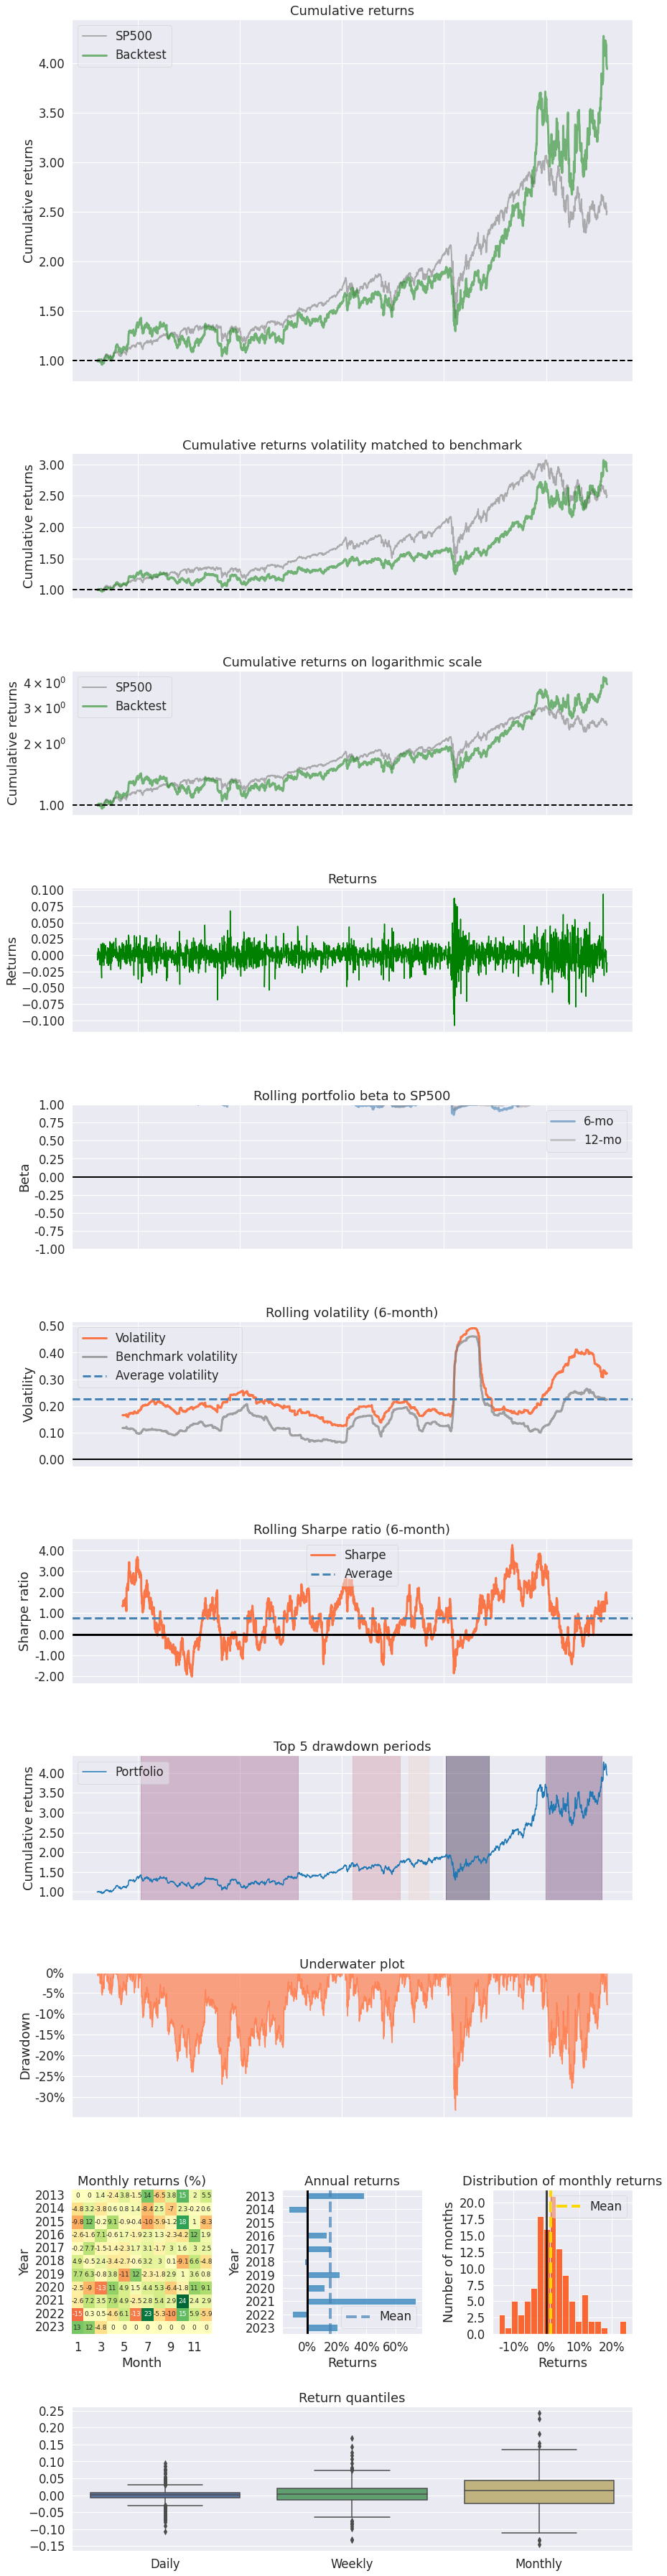

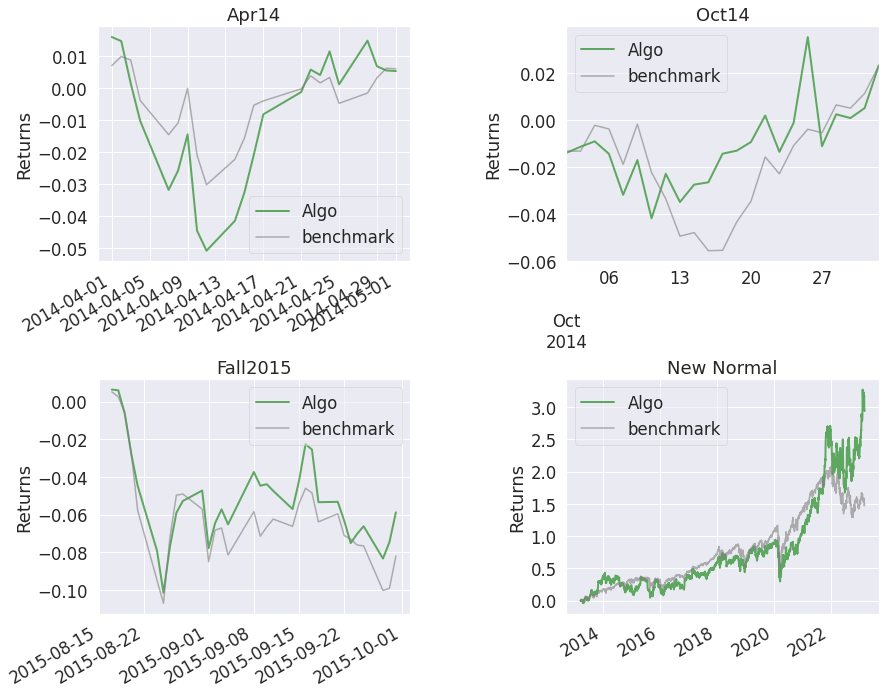

In [634]:
pf.create_full_tear_sheet(carteira["retorno"], benchmark_rets=retorno["SP500"])

In [ ]:
fig, ax1 = plt.subplots(figsize=(22,12))
pf.plot_rolling_beta(carteira["retorno"],factor_returns=retorno["SP500"], ax=ax1)
plt.ylim((0.5,2))